## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.0


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
font_dict = {'fontsize': 14,
            'fontweight' : plt.rcParams['axes.titleweight'],
            'verticalalignment': 'baseline'}
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14,7)

In [6]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='viridis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.style.use('seaborn-darkgrid')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data and Preprocessing

In [7]:
train_path = 'data/train'
test_path = 'data/test'
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [8]:
emotions = {0:'angry',
            1:'disgust',
            2:'fear',
            3:'happy',
            4:'neutral',
            5:'sad',
            6:'surprise'}

In [9]:
train_emotions = {em:0 for em in emotions.values()}
train_folder = os.path.join(os.getcwd(), train_path)
for folder in os.listdir(train_folder):
    train_emotions[folder]=len(os.listdir(os.path.join(train_folder, folder)))

In [10]:
test_emotions = {em:0 for em in emotions.values()}
test_folder = os.path.join(os.getcwd(), test_path)
for folder in os.listdir(test_folder):
    test_emotions[folder]=len(os.listdir(os.path.join(test_folder, folder)))

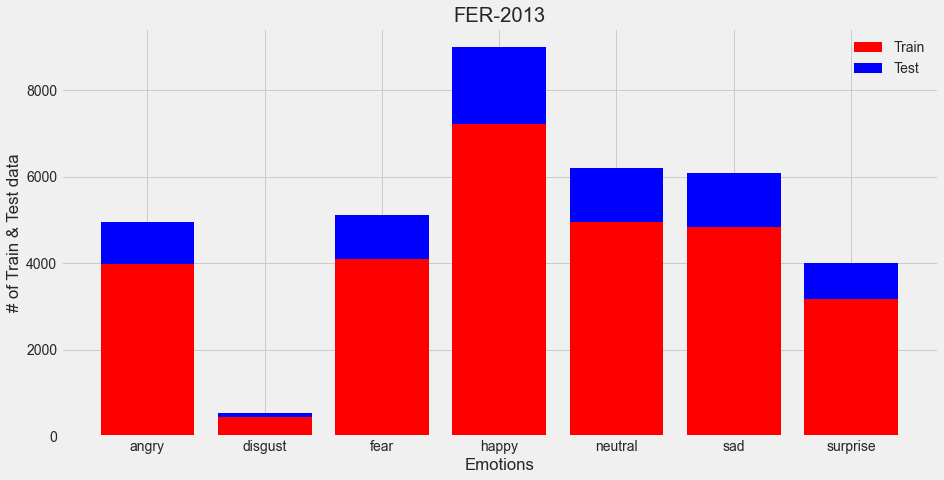

In [29]:
x = list(emotions.values())
y1 = list(train_emotions.values())
y2 = list(test_emotions.values())

plt.bar(x, y1, color='red')
plt.bar(x, y2, bottom=y1, color='blue')
plt.xlabel("Emotions")
plt.ylabel("# of Train & Test data")
plt.legend(["Train", "Test",])
plt.title("FER-2013")
plt.savefig('images/distribution.png')
plt.show()

In [12]:
datagenerator_train = ImageDataGenerator(rescale = (1/255.0),
                                   zoom_range=0.3,
                                   rotation_range=10,
                                   horizontal_flip=True)

datagenerator_test = ImageDataGenerator(rescale = (1/255.0))

In [13]:
train_generator = datagenerator_train.flow_from_directory(train_path, batch_size=64, classes=classes, target_size=(64,64))

test_generator = datagenerator_test.flow_from_directory(test_path, batch_size=64, classes=classes, target_size=(64,64), shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


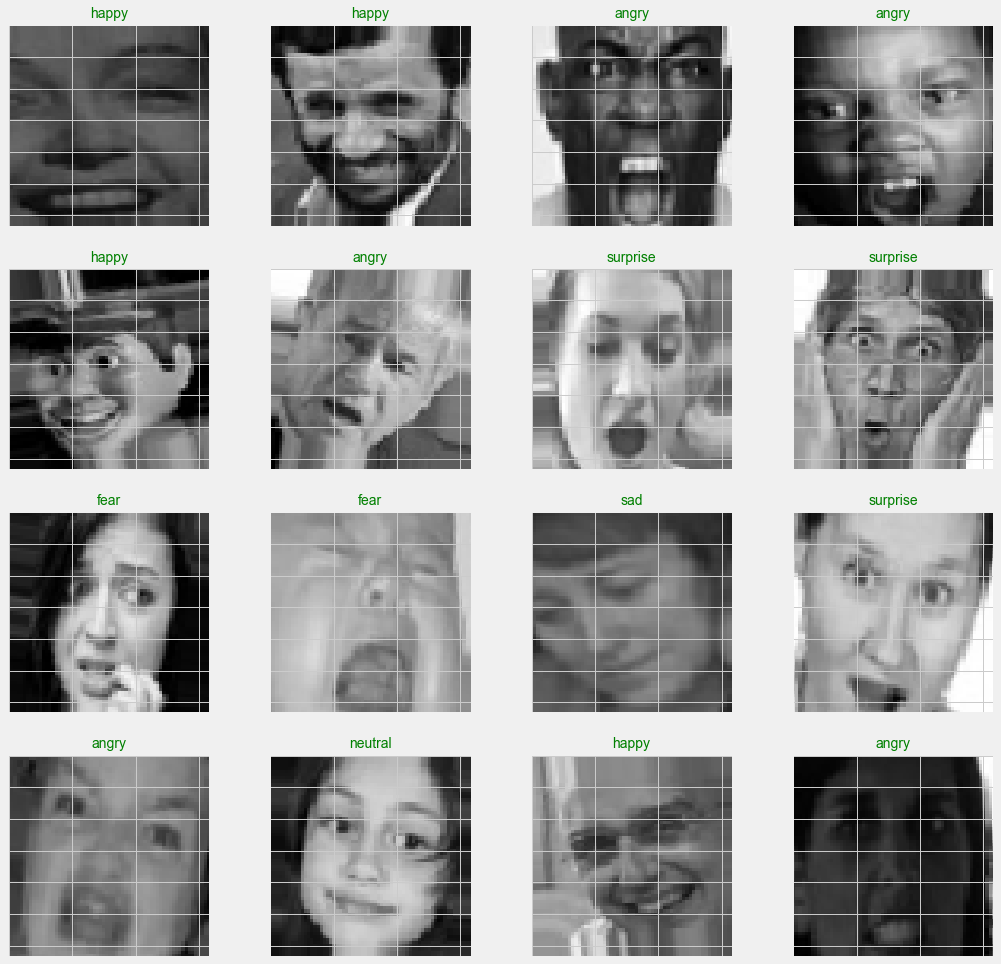

In [30]:
x,y = next(train_generator)
fig, ax = plt.subplots(4,4, figsize=(16,16))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(x[5*i+j])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xticklabels([])
        ax[i,j].set_title(emotions[np.argmax(y[5*i+j])],
                          fontdict = font_dict,
                          color='green')
fig.savefig('images/samples.png')

## Model Building

In [15]:
inputs = Input((64,64,3))

h = Conv2D(32, (3,3))(inputs)
h = BatchNormalization()(h)
h = tf.nn.relu(h)
h = Conv2D(64, (3,3))(h)
h = BatchNormalization()(h)
h = tf.nn.relu(h)

b = Conv2D(128, (1,1), strides = (2,2))(h)
b = BatchNormalization()(b)

h = SeparableConv2D(128, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = tf.nn.relu(h)
h = SeparableConv2D(128, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = MaxPooling2D((2,2))(h)

h = concatenate([h, b], name='first')

b = Conv2D(128, (1,1), strides = (2,2))(h)
b = BatchNormalization()(b)



h = SeparableConv2D(128, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = tf.nn.relu(h)
h = SeparableConv2D(128, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = MaxPooling2D((2,2), strides=(2,2))(h)

h = concatenate([h, b], name='second')


b = Conv2D(128, (1,1), padding='same')(h)
b = BatchNormalization()(b)
b = MaxPooling2D((2,2), strides=(2,2))(b)

h = SeparableConv2D(256, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = tf.nn.relu(h)
h = SeparableConv2D(256, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = MaxPooling2D((2,2), strides=(2,2))(h)


h = concatenate([h, b], name='third')
b = h


h = tf.nn.relu(h)
h = SeparableConv2D(256, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = tf.nn.relu(h)
h = SeparableConv2D(256, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = tf.nn.relu(h)
h = SeparableConv2D(256, (3,3), padding='same')(h)
h = BatchNormalization()(h)

h = concatenate([h, b], name='fourth')
b = h


h = tf.nn.relu(h)
h = SeparableConv2D(256, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = tf.nn.relu(h)
h = SeparableConv2D(256, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = tf.nn.relu(h)
h = SeparableConv2D(256, (3,3), padding='same')(h)
h = BatchNormalization()(h)


h = concatenate([h, b], name='fifth')
b = h


b = Conv2D(256, (1,1), strides = (1,1))(h)
b = BatchNormalization()(b)

h = tf.nn.relu(h)
h = SeparableConv2D(512, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = tf.nn.relu(h)
h = SeparableConv2D(512, (3,3), padding='same')(h)
h = BatchNormalization()(h)

h = concatenate([h, b], name='sixth')

h = SeparableConv2D(256, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = tf.nn.relu(h)

h = SeparableConv2D(256, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = tf.nn.relu(h)

h = GlobalAveragePooling2D()(h)

h = Dense(128, activation='relu')(h)
h = Dropout(0.4)(h)
h = Dense(64, activation='relu')(h)
h = Dropout(0.3)(h)
h = Dense(7, activation='softmax')(h)

outputs = h

model = Model(inputs, outputs)

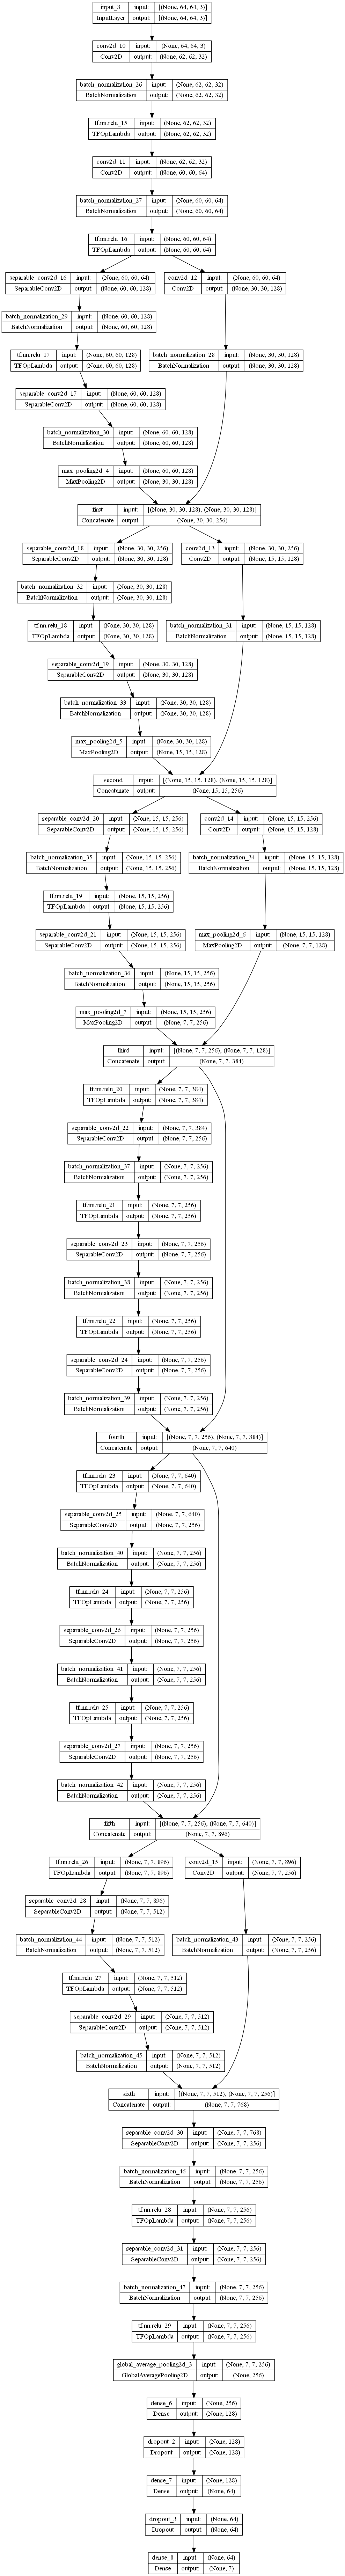

In [31]:
tf.keras.utils.plot_model(model, 'images/fer2013.png', show_shapes=True)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 62, 62, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 62, 62, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 tf.nn.relu (TFOpLambda)        (None, 62, 62, 32)   0           ['batch_normalization[0][0]']

 batch_normalization_8 (BatchNo  (None, 15, 15, 128)  512        ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 7, 7, 256)   0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 7, 7, 128)   0           ['batch_normalization_8[0][0]']  
                                                                                                  
 third (Concatenate)            (None, 7, 7, 384)    0           ['max_pooling2d_3[0][0]',        
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 tf.nn.rel

 ormalization)                                                                                    
                                                                                                  
 sixth (Concatenate)            (None, 7, 7, 768)    0           ['batch_normalization_19[0][0]', 
                                                                  'batch_normalization_17[0][0]'] 
                                                                                                  
 separable_conv2d_14 (Separable  (None, 7, 7, 256)   203776      ['sixth[0][0]']                  
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 7, 7, 256)   1024        ['separable_conv2d_14[0][0]']    
 ormalization)                                                                                    
          

## Compiling and Training

In [ ]:
model.compile(optimizer = Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
train_steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps_per_epoch = test_generator.n//test_generator.batch_size

In [ ]:
checkpoint = ModelCheckpoint('fer2013.h5',
                             monitor='val_accuracy',
                             verbose=0,
                             save_best_only=True)

es = EarlyStopping(monitor='val_accuracy',
                   min_delta=0.01,
                   patience=20,
                   mode='max',
                   restore_best_weights=True)

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator,
                        validation_data=test_generator,
                        validation_steps=validation_steps_per_epoch,
                        steps_per_epoch = train_steps_per_epoch,
                        epochs = 50,
                        verbose=2,
                        callbacks=[checkpoint, es])

## Plot Metrics

In [18]:
#loading saved model form training and its history
model = tf.keras.models.load_model('fer2013.h5')
hist = np.loadtxt('fer2013.txt')
val_acc = hist[3]
val_loss = hist[2]
test_acc = hist[1]
test_loss = hist[0]

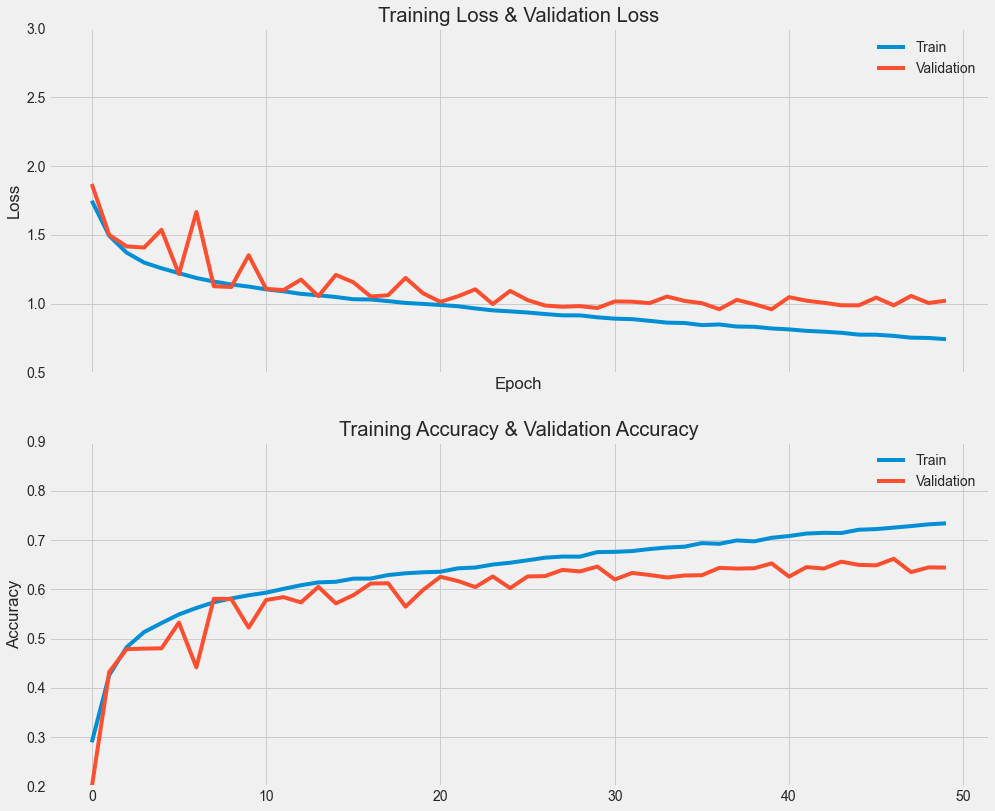

In [32]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,13), sharex=True)
'''
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

test_acc = history.history['accuracy']
test_loss = history.history['loss']
'''

ax1.plot(range(50), test_loss, label='loss')
ax1.plot(range(50), val_loss, label='val loss')
ax1.set_title('Training Loss & Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylim(bottom=0.5, top=3.)
ax1.legend(['Train', 'Validation'], loc='upper right');


ax2.plot(range(50), test_acc, label='accuracy')
ax2.plot(range(50), val_acc, label='val accuracy')
ax2.set_title('Training Accuracy & Validation Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(bottom=0.2, top=0.9)
ax2.legend(['Train', 'Validation'], loc='upper right');

fig.savefig('images/metrics.png')

In [20]:
# train scores
test_generator = datagenerator_test.flow_from_directory(test_path, batch_size=64, classes=classes, target_size=(64,64), shuffle=False)
y_true = test_generator.classes
y_hat =  model.predict(test_generator)
y_hat = tf.argmax(y_hat, axis = 1).numpy()
f1 = f1_score(y_true, y_hat, average='micro')
print('f1 score {}'.format(f1))

Found 7178 images belonging to 7 classes.
113/113 [==============================] - 118s 939ms/step
f1 score 0.6804123711340206


Confusion matrix, without normalization
[[ 660   16   47   22  106   94   13]
 [  28   71    2    3    2    5    0]
 [ 172    7  363   24  138  228   92]
 [  54    1   17 1535  111   38   18]
 [  91    3   32   57  887  156    7]
 [ 150    4   59   38  274  706   16]
 [  36    0   34   42   35   22  662]]


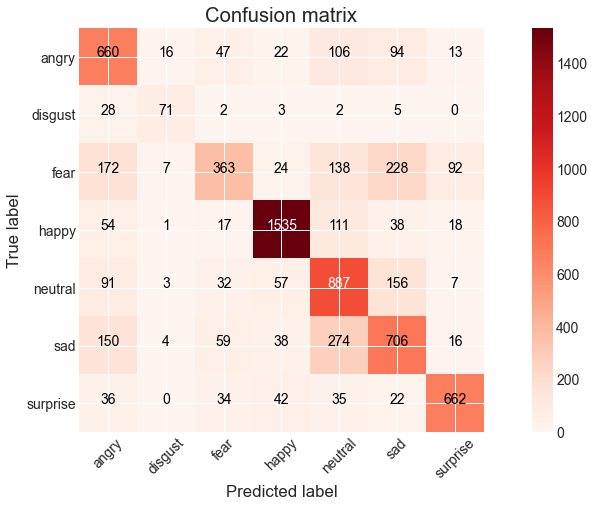

In [33]:
cm = confusion_matrix(y_true = y_true, y_pred = y_hat)
plot_confusion_matrix(cm, classes, cmap = 'Reds')
plt.savefig('images/confmat.png')